# Your company is Rossmann.
### Business issue : predict the stores turnover

Authors: BOIVIN Jolyanne, BOUCHER Axel, DE BROGLIE Aymon, GRIGNARD Jeremy, KARTHIGESU Dinojan, NAULET Antoine

### Table of contents

* Introduction
* Preprocessing
* Feature Engineering
* Validation strategy
* Training and evaluation

# Introduction

Rossmann is Germany's second drug store chain with 3600 stores in Europe. The objective of this notebook with respect to the Kaggle challenge is to predict the turnover (the sales) for each day for each store.
Predicting the turnover has huge positives impacts on companies such as :

* The possibility to optimize the supply chain and the stocking costs.
* It can give a dashboard to monitor the futur evolution of a store and make decisions about the stores.

The idea is to apply Machine Learning based solutions and check if it has a real added value and to which extend.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# Data Loading

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
store = pd.read_csv('data/store.csv')

/home/aymon/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# First Look 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
print('Here we can see that there are missing values for several features in store:', store.isnull().sum().sum())

Here we can see that there are missing values for several features in store: 2343


# Preprocessing

## Preprocessing on Train and Test

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


#### According to the documentation

* DateTime for Date
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


### Change the date to datetime object

In [12]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

### We first replace the '0' values present in the train and test set by 0 (int) Next we use get dummies for each present value

In [13]:
print("Train before", train['StateHoliday'].unique())
train.replace({"StateHoliday": {"0": 0}}, inplace=True)
print("Train Before", train['StateHoliday'].unique())

Train before ['0' 'a' 'b' 'c' 0]
Train Before [0 'a' 'b' 'c']


In [14]:
print("Test After", test['StateHoliday'].unique())
test.replace({"StateHoliday": {"0": 0}}, inplace=True)
print("Test After", test['StateHoliday'].unique())

Test After ['0' 'a']
Test After [0 'a']


In [15]:
train[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']] = pd.get_dummies(train['StateHoliday'])
test[['StateHoliday_0', 'StateHoliday_a']] = pd.get_dummies(test['StateHoliday'])
train.drop('StateHoliday', axis=1, inplace=True)
test.drop('StateHoliday', axis=1, inplace=True)

### Here we check the DayOfWeek for each Nan Values of the feature Open
#### As we can see in the celle below, there are no Sunday when the Open value is missing. Therefore can we replace the NaN values by 1 (the store is open). To be more realistic we should map the day with a American calendar to see if each day is a sunday, special day, close day, holiday, public bank holiday, but as there are only a few missing values it should not impact the results much

In [16]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a
479,480,622,4,2015-09-17,NaN,1,0,1,0
1335,1336,622,3,2015-09-16,NaN,1,0,1,0
2191,2192,622,2,2015-09-15,NaN,1,0,1,0
3047,3048,622,1,2015-09-14,NaN,1,0,1,0
4759,4760,622,6,2015-09-12,NaN,0,0,1,0
5615,5616,622,5,2015-09-11,NaN,0,0,1,0
6471,6472,622,4,2015-09-10,NaN,0,0,1,0
7327,7328,622,3,2015-09-09,NaN,0,0,1,0
8183,8184,622,2,2015-09-08,NaN,0,0,1,0
9039,9040,622,1,2015-09-07,NaN,0,0,1,0


In [17]:
test.replace({"Open": {np.nan: 1}}, inplace=True)

In [18]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a


Finally , we are not evaluated at dates where the store is closed so we can get rid of those dates. The we can get rid of the Open features which carries no more  information 

In [19]:
train = train[train['Open'] != 0 ]
test = test[test['Open'] != 0 ]
del train['Open']
del test['Open']

## Preprocessing on Store

In [20]:
objectFeaturesStore = ['StoreType', 'Assortment', 'PromoInterval']

In [21]:
store[objectFeaturesStore].head()

,StoreType,Assortment,PromoInterval
0,c,a,NaN
1,a,a,"Jan,Apr,Jul,Oct"
2,a,a,"Jan,Apr,Jul,Oct"
3,c,c,NaN
4,a,a,NaN


According to the documentation

* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


#### Replace missing values by mean 

In [22]:
# Features to preprocess numerically
# 3 features are object type
featuresToPreprocessByMean = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear']

In [23]:
for idx in featuresToPreprocessByMean:
    store[idx] = store[idx].fillna(np.mean(store[idx]))

In [24]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### StoreType, Assortment, PromoInterval

In [25]:
print('distinct_storeType:', store['StoreType'].unique(), '\ndistinct_assortment: ', store['Assortment'].unique(), '\ndistinct_promoInterval: ', store['PromoInterval'].unique())

distinct_storeType: ['c' 'a' 'd' 'b'] 
distinct_assortment:  ['a' 'c' 'b'] 
distinct_promoInterval:  [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [26]:
store[['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']] = pd.get_dummies(store['StoreType'])
store[['Assortment_a', 'Assortment_b', 'Assortment_c']] = pd.get_dummies(store['Assortment'])
store.drop('StoreType', axis=1, inplace=True)
store.drop('Assortment', axis=1, inplace=True)

In [27]:
store.replace({"PromoInterval": {np.nan: 0}}, inplace=True)

In [28]:
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,1270.0,9.0,2008.0,0,23.595447,2011.763573,0,0,0,1,0,1,0,0
1,2,570.0,11.0,2007.0,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
2,3,14130.0,12.0,2006.0,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
3,4,620.0,9.0,2009.0,0,23.595447,2011.763573,0,0,0,1,0,0,0,1
4,5,29910.0,4.0,2015.0,0,23.595447,2011.763573,0,1,0,0,0,1,0,0


In [29]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 15 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
StoreType_a                  1115 non-null uint8
StoreType_b                  1115 non-null uint8
StoreType_c                  1115 non-null uint8
StoreType_d                  1115 non-null uint8
Assortment_a                 1115 non-null uint8
Assortment_b                 1115 non-null uint8
Assortment_c                 1115 non-null uint8
dtypes: float64(5), int64(2), object(1), uint8(7)
memory usage: 77.4+ KB


We are going to add two featuresat shows the date when competition opened and one showing the date when promo2 began, those features will help for predicting as well as for building other features of interest.  

In [30]:
def date_init_compet (col1, col2):
    if col1 != 0:
        return pd.to_datetime(str('01/')+str((int(col1)))+"/"+str(int(col2)))
    
def date_init_promo(week,year):
    if week != 0: 
        return pd.to_datetime(str(int(week)) + '/' + str(int(year)) + '/' + '0', format='%W/%Y/%w')
    
store['BeginCompetition'] = store.apply(lambda x : date_init_compet(x['CompetitionOpenSinceMonth'], x['CompetitionOpenSinceYear']),axis=1) 
store['BeginPromo2'] = store.apply(lambda x : date_init_promo(x['Promo2SinceWeek'], x['Promo2SinceYear']),axis=1) 

    
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,BeginCompetition,BeginPromo2
0,1,1270.0,9.0,2008.0,0,23.595447,2011.763573,0,0,0,1,0,1,0,0,2008-01-09,2011-06-12
1,2,570.0,11.0,2007.0,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2007-01-11,2010-04-04
2,3,14130.0,12.0,2006.0,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2006-01-12,2011-04-10
3,4,620.0,9.0,2009.0,0,23.595447,2011.763573,0,0,0,1,0,0,0,1,2009-01-09,2011-06-12
4,5,29910.0,4.0,2015.0,0,23.595447,2011.763573,0,1,0,0,0,1,0,0,2015-01-04,2011-06-12


In [31]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
StoreType_a                  1115 non-null uint8
StoreType_b                  1115 non-null uint8
StoreType_c                  1115 non-null uint8
StoreType_d                  1115 non-null uint8
Assortment_a                 1115 non-null uint8
Assortment_b                 1115 non-null uint8
Assortment_c                 1115 non-null uint8
BeginCompetition             1115 non-null datetime64[ns]
BeginPromo2                  1115 non-null datetime64[ns]
dtypes: datetime64[ns](2), floa

#### Merge Train,Test and Store

In [32]:
train.columns, test.columns,store.columns, 

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
        'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
        'StateHoliday_c'],
       dtype='object'),
 Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Promo', 'SchoolHoliday',
        'StateHoliday_0', 'StateHoliday_a'],
       dtype='object'),
 Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
        'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
        'Assortment_c', 'BeginCompetition', 'BeginPromo2'],
       dtype='object'))

In [33]:
df_train = pd.merge(train, store, left_on='Store', right_on='Store')
df_test = pd.merge(test, store, left_on='Store', right_on='Store')

In [34]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,BeginCompetition,BeginPromo2
0,1,5,2015-07-31,5263,555,1,1,1,0,0,...,0,0,0,1,0,1,0,0,2008-01-09,2011-06-12
1,1,4,2015-07-30,5020,546,1,1,1,0,0,...,0,0,0,1,0,1,0,0,2008-01-09,2011-06-12
2,1,3,2015-07-29,4782,523,1,1,1,0,0,...,0,0,0,1,0,1,0,0,2008-01-09,2011-06-12
3,1,2,2015-07-28,5011,560,1,1,1,0,0,...,0,0,0,1,0,1,0,0,2008-01-09,2011-06-12
4,1,1,2015-07-27,6102,612,1,1,1,0,0,...,0,0,0,1,0,1,0,0,2008-01-09,2011-06-12


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 27 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null datetime64[ns]
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Promo                        844392 non-null int64
SchoolHoliday                844392 non-null int64
StateHoliday_0               844392 non-null uint8
StateHoliday_a               844392 non-null uint8
StateHoliday_b               844392 non-null uint8
StateHoliday_c               844392 non-null uint8
CompetitionDistance          844392 non-null float64
CompetitionOpenSinceMonth    844392 non-null float64
CompetitionOpenSinceYear     844392 non-null float64
Promo2                       844392 non-null int64
Promo2SinceWeek              844392 non-null float64
Promo2SinceYear              844392 non-null float64
Pro

# Feature Engineering

In this part, we will create  features which might be helpful to improve the model.

In [36]:
#This function returns 1 if there is a romo2 "today" 1 otherwise  
def create_promo2(promo, curr_date,begin_date, interval ):
    list_mois = ['Jan','Feb','Mar', 'Apr','May','Jun', 'Jul', 'Aug', 'Sept', 'Oct','Nov','Dec']
    if promo  and (curr_date > begin_date) and (list_mois[curr_date.month -1 ] in interval.split(',')):
        return 1 
    else:
        return 0 

In [37]:
# Creates all the features we might need to train ours models
def generator (df) :
    #Time since opoosition began
    df['duree_concurence']= (df['Date'] - pd.to_datetime(df['BeginCompetition'])).dt.days
    #1 if there is a promo2 today, 0 otherwise 
    df['promo2_today'] =df.apply( lambda x : create_promo2(x['Promo2'],x['Date'], x['BeginPromo2'] , x['PromoInterval']),axis = 1 )
    df['year']=df['Date'].apply(lambda x: x.year)
    df['month']=df['Date'].apply(lambda x: x.month)
    df['day']=df['Date'].apply(lambda x: x.day)
    df['dayofyear']=df['Date'].apply(lambda x: x.dayofyear)
    df['weekofyear']=df['Date'].apply(lambda x: x.weekofyear)
    df['dayofweek']=df['Date'].apply(lambda x: x.dayofweek)
    df['quarter']=df['Date'].apply(lambda x: x.quarter)
    
    #The length of time promo2 has been ongoing in a given store
    df['duree_promo2'] = (df['Date'] - df['BeginPromo2']).dt.days

    return (df)

We now have the datasets for training and testing with all the features we created above. The following dataframes are used as lake of features where we have all the features we thought about. We well then select some features in the following validation strategy part.

In [38]:
df_train = generator(df_train) # "Lake" of data for Training
df_test = generator(df_test) # "Lake" of data for test to submit on Kaggle

In [39]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,5,2015-07-31,5263,555,1,1,1,0,0,...,2760,0,2015,7,31,212,31,4,3,1510
1,1,4,2015-07-30,5020,546,1,1,1,0,0,...,2759,0,2015,7,30,211,31,3,3,1509
2,1,3,2015-07-29,4782,523,1,1,1,0,0,...,2758,0,2015,7,29,210,31,2,3,1508
3,1,2,2015-07-28,5011,560,1,1,1,0,0,...,2757,0,2015,7,28,209,31,1,3,1507
4,1,1,2015-07-27,6102,612,1,1,1,0,0,...,2756,0,2015,7,27,208,31,0,3,1506


In [40]:
df_test.head()

,Id,Store,DayOfWeek,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,CompetitionDistance,CompetitionOpenSinceMonth,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,1,4,2015-09-17,1,0,1,0,1270.0,9.0,...,2808,0,2015,9,17,260,38,3,3,1558
1,857,1,3,2015-09-16,1,0,1,0,1270.0,9.0,...,2807,0,2015,9,16,259,38,2,3,1557
2,1713,1,2,2015-09-15,1,0,1,0,1270.0,9.0,...,2806,0,2015,9,15,258,38,1,3,1556
3,2569,1,1,2015-09-14,1,0,1,0,1270.0,9.0,...,2805,0,2015,9,14,257,38,0,3,1555
4,4281,1,6,2015-09-12,0,0,1,0,1270.0,9.0,...,2803,0,2015,9,12,255,37,5,3,1553


### Score

We will establish a scoring metric to evaluate the quality of our model. The metric used will be the same the one used on Kaggle which is the rmspe. This allows us to compution the percentage of error we make on average 

In [41]:
def rmspe(yhat, y):  
    sum_ = 0
    for i in range(len(y)):
        if(y[i] != 0):
            sum_ += ((y[i] - yhat[i]) / y[i]) ** 2   
    rmspe = np.sqrt(sum_ / len(y))
        
    return rmspe

# adapted metric for xgboost
def rmspe_xg(yhat, y):
    return "rmspe", rmspe(yhat, y.get_label())

# Naive Approach

We try in this part what we call a naive approach. The idea behind this approach is that the board will probably ask the salers to do as well as the previous years or better. This should make the actual sales oscillate around a certain value that we estimate by the mean.
Thus, to predict the sale for a given date, we look at what the store sold the previous years for the same date and we take the mean. 

In [42]:
class Naive:
    
    def same_day(self,day1,day2):
        """Return true if day1 and day 2 are the same day juste different year"""
        return (day1.day == day2.day) and (day1.month ==day2.month)
    
    def train(self,data,target):
        """Trains the model"""
        #Compute the mean aggregate by Days
        X = pd.concat([data['Date'].copy() , target.copy()],axis=1)
        X['Date'] = X['Date'].apply(lambda x : (x.day,x.month))
        self.aggregate = X.groupby(['Date']).mean().reset_index()

    def predict(self,X): 
        """Predicts sales"""
        X = X.copy()
        X['Date'] = X['Date'].apply(lambda x : (x.day,x.month))
        # Merge with the aggregate
        pred = pd.merge(pd.DataFrame(X['Date']), self.aggregate, left_on='Date', right_on='Date')
        return np.array(pred['Sales'])

In [43]:
naive_model = Naive()
naive_model.train(df_train,df_train['Sales'])

y_train_pred = naive_model.predict(df_train)

print('Error on training set ', rmspe(y_train_pred, df_train['Sales'].values))

Error on training set  0.683739371352


In [44]:
#Evaluate it on the kaggle dataset
prediction = naive_model.predict(df_test)
indic = test['Id']
res = pd.DataFrame(indic)
res['Sales'] = prediction
res.to_csv('data/submission_naive.csv', index = False)

The Naive approach gives a rmspe score of 0.54591 on Kaggle 

# Validation strategy

In this part we will first split the train set to have a validation and train set.
Then we will choose the features we want to keep to train our model, from the lake of features we created in the previous part.
We will apply our selection to training, validation and test sets.

### Split into train and validation set

In [45]:
train, validation = train_test_split(df_train, test_size=0.3)

In [46]:
train.shape, validation.shape

((591074, 37), (253318, 37))

### Feature Selection

In [47]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'BeginCompetition', 'BeginPromo2', 'duree_concurence',
       'promo2_today', 'year', 'month', 'day', 'dayofyear', 'weekofyear',
       'dayofweek', 'quarter', 'duree_promo2'],
      dtype='object')

In [48]:
featuresToTakeForTraining = ['Store', 'DayOfWeek', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'duree_concurence', 'promo2_today', 'year', 'month', 'day', 'dayofyear',
       'weekofyear', 'dayofweek', 'quarter', 'duree_promo2']

In [49]:
y_train = train['Sales']
y_validation = validation['Sales']

X_train = train[featuresToTakeForTraining]
X_validation = validation[featuresToTakeForTraining]
X_test = df_test[featuresToTakeForTraining]

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591074 entries, 165081 to 598386
Data columns (total 27 columns):
Store                        591074 non-null int64
DayOfWeek                    591074 non-null int64
Promo                        591074 non-null int64
SchoolHoliday                591074 non-null int64
CompetitionDistance          591074 non-null float64
CompetitionOpenSinceMonth    591074 non-null float64
CompetitionOpenSinceYear     591074 non-null float64
Promo2                       591074 non-null int64
Promo2SinceWeek              591074 non-null float64
Promo2SinceYear              591074 non-null float64
StoreType_a                  591074 non-null uint8
StoreType_b                  591074 non-null uint8
StoreType_c                  591074 non-null uint8
StoreType_d                  591074 non-null uint8
Assortment_a                 591074 non-null uint8
Assortment_b                 591074 non-null uint8
Assortment_c                 591074 non-null uint8
duree_c

In [51]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Promo                        35104 non-null int64
SchoolHoliday                35104 non-null int64
CompetitionDistance          35104 non-null float64
CompetitionOpenSinceMonth    35104 non-null float64
CompetitionOpenSinceYear     35104 non-null float64
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null float64
Promo2SinceYear              35104 non-null float64
StoreType_a                  35104 non-null uint8
StoreType_b                  35104 non-null uint8
StoreType_c                  35104 non-null uint8
StoreType_d                  35104 non-null uint8
Assortment_a                 35104 non-null uint8
Assortment_b                 35104 non-null uint8
Assortment_c                 35104 non-null uint8
duree_concurence             35

# Training Pipeline

In [52]:
# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Grid search
from sklearn.model_selection import GridSearchCV

### XGboost implementation that we train separatly

In [53]:
def get_prob(y):
    y[y < 0] = 0
    return y

In [54]:
params = {"objective": "reg:linear", # loss => linear regression because we predict sales
          "eta": 0.3,
          "max_depth": 8, #we can increase the depth but we might overfit
          "subsample": 0.7,
          "colsample_bytree": 0.7
          }

dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))

dvalid = xgb.DMatrix(X_validation, np.log(y_validation + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 200, evals = watchlist, early_stopping_rounds = 30, feval = rmspe_xg, verbose_eval = 5)

[0]	eval-rmse:5.79465	train-rmse:5.79454	eval-rmspe:0.659592	train-rmspe:0.65959
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 30 rounds.
[5]	eval-rmse:1.02589	train-rmse:1.0262	eval-rmspe:0.114346	train-rmspe:0.114358
[10]	eval-rmse:0.336639	train-rmse:0.337462	eval-rmspe:0.036956	train-rmspe:0.036933
[15]	eval-rmse:0.265889	train-rmse:0.266643	eval-rmspe:0.029744	train-rmspe:0.029684
[20]	eval-rmse:0.241673	train-rmse:0.242382	eval-rmspe:0.027096	train-rmspe:0.027023
[25]	eval-rmse:0.225412	train-rmse:0.22558	eval-rmspe:0.025224	train-rmspe:0.025129
[30]	eval-rmse:0.207525	train-rmse:0.207313	eval-rmspe:0.023129	train-rmspe:0.023012
[35]	eval-rmse:0.192682	train-rmse:0.191739	eval-rmspe:0.021354	train-rmspe:0.021208
[40]	eval-rmse:0.181545	train-rmse:0.18061	eval-rmspe:0.02002	train-rmspe:0.019868
[45]	eval-rmse:0.174702	train-rmse:0.173336	eval-rmspe:0.0192	train-rmspe:0.019011
[50]	eval-rmse:0

In [55]:
train_probs = model.predict(xgb.DMatrix(X_train))
validation_probs = model.predict(xgb.DMatrix(X_validation))

print('Error on training set ', rmspe(np.exp(get_prob(train_probs))-1, y_train.values))
print('Error on validation set ', rmspe(np.exp(get_prob(validation_probs))-1, y_validation.values))

Error on training set  0.115128599331
Error on validation set  0.125278311972


### If we try to select some features in order to decrease the RMSPE

In [56]:
featuresToTakeForTraining = ['Store', 'DayOfWeek', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c','year', 'month', 'day']

y_train = train['Sales']
y_validation = validation['Sales']

X_train = train[featuresToTakeForTraining]
X_validation = validation[featuresToTakeForTraining]
X_test = df_test[featuresToTakeForTraining]

In [57]:
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))

dvalid = xgb.DMatrix(X_validation, np.log(y_validation + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 300, evals = watchlist, early_stopping_rounds = 30, feval = rmspe_xg, verbose_eval = 10)

[0]	eval-rmse:5.79384	train-rmse:5.79362	eval-rmspe:0.659652	train-rmspe:0.659638
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 30 rounds.
[10]	eval-rmse:0.339372	train-rmse:0.340455	eval-rmspe:0.037237	train-rmspe:0.0372
[20]	eval-rmse:0.247323	train-rmse:0.24866	eval-rmspe:0.02778	train-rmspe:0.027719
[30]	eval-rmse:0.219627	train-rmse:0.220898	eval-rmspe:0.024503	train-rmspe:0.024433
[40]	eval-rmse:0.187546	train-rmse:0.18892	eval-rmspe:0.020712	train-rmspe:0.020617
[50]	eval-rmse:0.172756	train-rmse:0.17381	eval-rmspe:0.018869	train-rmspe:0.018736
[60]	eval-rmse:0.15951	train-rmse:0.160243	eval-rmspe:0.017224	train-rmspe:0.01704
[70]	eval-rmse:0.154308	train-rmse:0.154447	eval-rmspe:0.016558	train-rmspe:0.01633
[80]	eval-rmse:0.149199	train-rmse:0.148959	eval-rmspe:0.015914	train-rmspe:0.015659
[90]	eval-rmse:0.144459	train-rmse:0.143744	eval-rmspe:0.015296	train-rmspe:0.015016
[100]	eval-rmse

In [58]:
train_probs = model.predict(xgb.DMatrix(X_train))
validation_probs = model.predict(xgb.DMatrix(X_validation))

print('Error on training set ', rmspe(np.exp(get_prob(train_probs))-1, y_train.values))
print('Error on validation set ', rmspe(np.exp(get_prob(validation_probs))-1, y_validation.values))

Error on training set  0.145166455157
Error on validation set  0.124186056094


### Different Sklearn Regressors implementations

##### Definition of the algorithm and theirs parameters for the grid search

In [59]:
names_regressors = ["DecisionTreeRegressor", "RandomForestRegressor", "ExtraTreesRegressor", "XGBoost"]

regressors = [
    DecisionTreeRegressor(max_depth=None, min_samples_split=2, random_state=0),
    RandomForestRegressor(n_estimators = 10, max_depth = None, min_samples_split = 2, random_state = 0),
    ExtraTreesRegressor(n_estimators = 10, max_depth = None, min_samples_split = 2, random_state = 0),
    model
    ]

##### Training of the different algoritms

In [65]:
scores = []
scores_train = []

# iterate over classifiers
for clf, name in zip(regressors, names_regressors):
    print (name)
    if(name != "XGBoost"):
        clf.fit(X_train, np.log(y_train+1))
        y_pred = clf.predict(X_validation)
        y_pred_train = clf.predict(X_train)
        score_train = rmspe(np.exp(y_pred_train) -1 , y_train.values)
        score = rmspe(np.exp(y_pred) -1 , y_validation.values)
        print("\t Score (trainning):", score_train, "\n")
        print("\t Score (testing):", score, "\n")
    else:
        train_probs = clf.predict(xgb.DMatrix(X_train))
        test_probs = clf.predict(xgb.DMatrix(X_validation))
        score_train = rmspe(np.exp(get_prob(train_probs)) - 1, y_train.values)
        score = rmspe(np.exp(get_prob(test_probs)) - 1, y_validation.values)
        print("\t Score (trainning):", score_train, "\n")
        print("\t Score (testing):", score, "\n")
    scores.append(score)
    scores_train.append(score_train)


DecisionTreeRegressor
	 Score (trainning): 1.9264258533e-05 

	 Score (testing): 0.205749231333 

RandomForestRegressor
	 Score (trainning): 0.0606355068939 

	 Score (testing): 0.151728503141 

ExtraTreesRegressor
	 Score (trainning): 7.65179548658e-06 

	 Score (testing): 0.154826032933 

XGBoost
	 Score (trainning): 0.145166455157 

	 Score (testing): 0.124186056094 



##### Plot the different scores

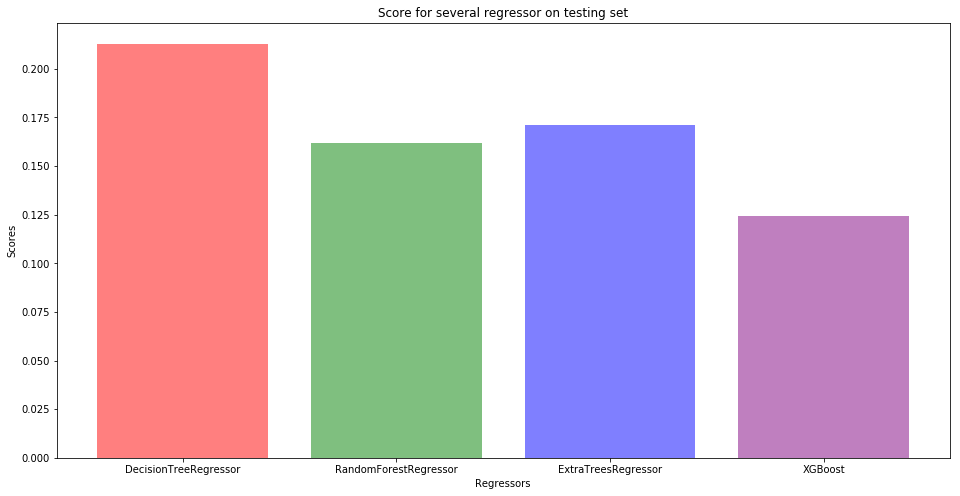

In [61]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores))
plt.bar(x, scores, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Regressors")
plt.ylabel("Scores")
plt.title("Score for several regressor on testing set")
plt.show()

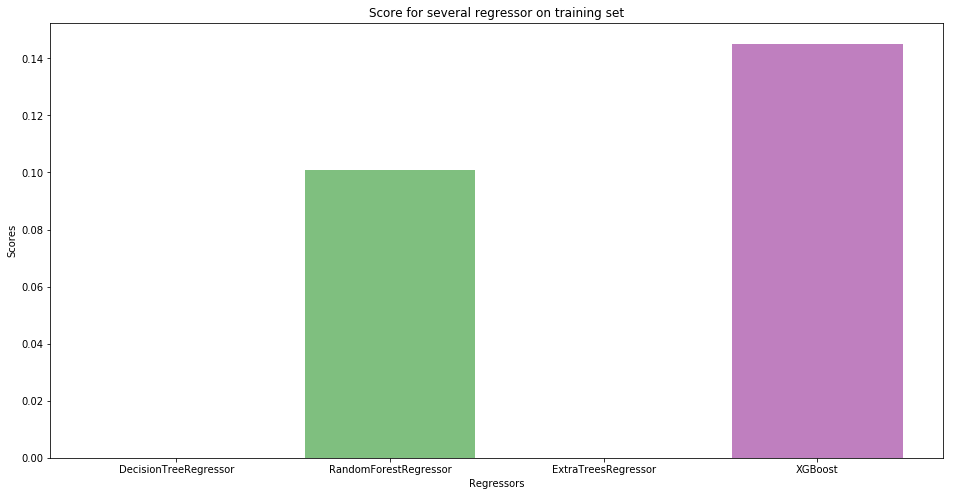

In [62]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores))
plt.bar(x, scores_train, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Regressors")
plt.ylabel("Scores")
plt.title("Score for several regressor on training set")
plt.show()

# Evaluation and Comparison

Show the best features

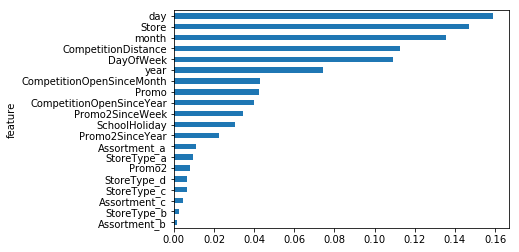

In [63]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
#Store in dataframe for plotting 
importance = pd.DataFrame(importance,columns = ['feature','score'])
#Make the score relative 
importance['score'] = importance['score']/importance['score'].sum()
importance.plot(kind ='barh' , x = 'feature' , y = 'score',legend = False)

To conclude, we can compare one naive approach presented above to the machine learning approaches. Even if the naive approach has a kaggle rmspe of 0.54591, we can get way better models using the different ML approaches shown in the notebook  to reach rmspe of 0.19.
Those nice fitting models will give the different possibi

# Submission Generation for Kaggle

In [64]:
def to_submit(model):
    ypred=model.predict(X_test) #X_test is already pre_processed
    submission = pd.DataFrame({"Id": df_test["Id"], "Sales": ypred})
    submission.to_csv("submission_xgb.csv", index=False)